In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import gc

import matplotlib.pyplot as plt
import seaborn as sns

import os
import warnings
warnings.filterwarnings('ignore')

In [2]:
import keras
import tensorflow as tf
import keras.backend as K
from keras import optimizers, callbacks
from keras.layers import Dense, Concatenate, Activation, Add, BatchNormalization, Dropout
from keras.models import Input, Model, Sequential, load_model
from keras.optimizers import Adam, SGD, RMSprop

from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import random

SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
os.environ['PYTHONHASHSEED']=str(SEED)
random.seed(SEED)
# tf.config.set_visible_devices(tf.config.list_physical_devices('CPU'))
# logical_devices = tf.config.list_logical_devices('CPU')
# os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
# os.environ["CUDA_VISIBLE_DEVICES"] = ""
# tf.config.experimental.set_visible_devices([], 'GPU')
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        # 프로그램 시작시에 메모리 증가가 설정되어야만 합니다
        print(e)

def mape(y_true, y_pred):
    return 100*np.mean((np.abs(y_true-y_pred)/y_true))

def mish(x):
    return x*K.tanh(K.softplus(x))

def decay(epochs):
    init = 1e-3
    drop = 25
    ratio = 0.9
    return max(5e-5, (init * (ratio ** (epochs//drop))))    


def Denseblock(n, activation=mish, bn=False):
    def f(x):
        x = Dense(n)(x)
        if bn:
            x = BatchNormalization()(x)
        x = Activation(activation)(x)
        return x
    return f

es = callbacks.EarlyStopping(patience=10, restore_best_weights=True)
lrs = callbacks.LearningRateScheduler(decay, verbose=0)


Using TensorFlow backend.


In [3]:
class GAN:
    def __init__(self, y_shape, x_shape): # latent = c_shape
        # data structure
        self.y_shape = y_shape
        self.x_shape = x_shape
        
        self.score = float('inf')
        self.mapes = []
        self.maes = []
        
        # build model
        self.gen = self.build_generator()
        self.disc = self.build_discriminator()
        
        inputs_x = Input(shape = self.x_shape[1:])
        inputs_y = Input(shape = self.y_shape[1:])
        
        pred_y = self.gen(inputs_x)

        self.disc.compile(optimizer=RMSprop(2e-4), loss='binary_crossentropy')
        self.disc.trainable = False

        valid = self.disc([inputs_x, pred_y])
        
        self.gan = Model([inputs_x, inputs_y], [valid, pred_y], name='GAN')
        self.gan.compile(optimizer=RMSprop(2e-4), loss=['binary_crossentropy']+['mae'], loss_weights=[1, 100])
        
    
    def build_generator(self):
        inputs = Input(shape = self.x_shape[1:])
        
        x = Denseblock(64)(inputs)
        x = Denseblock(32)(x)
#         x = Denseblock(32)(x)

        outputs = Dense(self.y_shape[1])(x)
        
        gen = Model(inputs, outputs, name='generator')
        
        return gen
    
    def build_discriminator(self):
        inputs_y = Input(shape = self.y_shape[1:])
        inputs_x = Input(shape = self.x_shape[1:])
        
        inputs = Concatenate()([inputs_x, inputs_y])
        
        x = Denseblock(64)(inputs)
        x = Denseblock(32)(x)
        
        outputs = Dense(1, activation='sigmoid')(x)
        
        disc = Model([inputs_x, inputs_y], outputs, name='discriminator')
        
        return disc

In [4]:
gan = GAN((1, 24), (1, 57))

In [5]:
gan.gan.load_weights('./best.h5')

In [6]:
data = pd.read_csv('./test0.csv')

In [7]:
data['time'] = np.repeat(range(data.shape[0]//4), 4)
X = []
for i in range(0, data.shape[0]//4, 24):
    X.append(data.groupby('time').sum()['value'][i:i+24].values)
    
X = np.array(X)

In [8]:
data

,date,value,time
0,2020-10-13T00:15:00+09:00,0.0,0
1,2020-10-13T00:30:00+09:00,0.0,0
2,2020-10-13T00:45:00+09:00,0.0,0
3,2020-10-13T01:00:00+09:00,0.0,0
4,2020-10-13T01:15:00+09:00,0.0,1
...,...,...,...
91,2020-10-13T23:00:00+09:00,0.0,22
92,2020-10-13T23:15:00+09:00,0.0,23
93,2020-10-13T23:30:00+09:00,0.0,23
94,2020-10-13T23:45:00+09:00,0.0,23


In [9]:
X = np.array(X)

In [32]:
DATE = '20201014'

In [43]:
import requests
import json

key = "o7xyQ0fITWYeMRMAcZil3XRm6ilk4ZOR5oUpSOw56FAc2DcQml0Z8h7OgLUHy0i5OXuoX2UoOSNKBdvEAyY9Ug%3D%3D"
url = 'http://apis.data.go.kr/1360000/VilageFcstInfoService/getVilageFcst'

req_data = {
    "dataType": "JSON",
    "serviceKey": key,
    "nx": "68",
    "ny": "111",
    "base_date": DATE,
    "base_time": "0200",
    'numOfRows': '999',
}

req = url + '?'
for k, i in req_data.items():
    req += f'{k}={i}'
    req += '&'

req = req[:-1]
data = requests.get(req)

data = json.loads(data.text)
ds = data['response']['body']['items']['item']

res = {}

for dt in ds:
    if dt['fcstDate'] not in res.keys():
        res[dt['fcstDate']] = {}

    if dt['fcstTime'] not in res[dt['fcstDate']].keys():
        res[dt['fcstDate']][dt['fcstTime']] = {}

    res[dt['fcstDate']][dt['fcstTime']][dt['category']] = dt['fcstValue']
    
df = pd.DataFrame.from_dict(res[DATE])
df.fillna(0, inplace=True)

In [38]:
df = df.iloc[:,3:]
df

,0900,1200,1500,1800,2100
POP,20,20,0,0,0
PTY,0,0,0,0,0
R06,0,0,0,0,0
REH,55,35,30,50,75
S06,0,0,0,0,0
SKY,3,3,1,1,1
T3H,8,15,17,13,9
UUU,0.5,0.8,1,1,0.8
VEC,301,318,324,315,297
VVV,-0.3,-0.9,-1.4,-1,-0.4


In [51]:
df

,0600,0900,1200,1500,1800,2100
POP,30,30,30,20,20,20
PTY,0,0,0,0,0,0
R06,0,0,0,0,0,0
REH,85,75,50,35,45,60
S06,0,0,0,0,0,0
SKY,4,4,4,3,3,3
T3H,9,13,16,17,13,9
TMN,8.0,0,0,0,0,0
UUU,0,0.6,1,2,1.2,0.8
VEC,171,304,322,303,310,311


In [44]:
cols = ['3시간기온_9', '3시간기온_12', '3시간기온_15', '3시간기온_18', '3시간기온_21', '6시간강수량_9',
       '6시간강수량_12', '6시간강수량_15', '6시간강수량_18', '6시간강수량_21', '강수형태_9', '강수형태_12',
       '강수형태_15', '강수형태_18', '강수형태_21', '강수확률_9', '강수확률_12', '강수확률_15',
       '강수확률_18', '강수확률_21', '습도_9', '습도_12', '습도_15', '습도_18', '습도_21',
       '일최고기온', '일최저기온', '풍속_9', '풍속_12', '풍속_15', '풍속_18', '풍속_21', '일교차']

In [45]:
w = []
w += list(map(lambda x: int(x), df.loc['T3H'].values[1:]))
w += list(map(lambda x: int(x), df.loc['S06'].values[1:]))
w += list(map(lambda x: int(x), df.loc['PTY'].values[1:]))
w += list(map(lambda x: int(x)/100, df.loc['POP'].values[1:]))
w += list(map(lambda x: int(x)/100, df.loc['REH'].values[1:]))
w += [max(df.loc['TMX'].values.astype('float'))]
w += [min(df.loc['TMN'].values.astype('float'))]
w += list(map(lambda x: float(x), df.loc['WSD'].values[1:].astype('float')))
w += [max(df.loc['TMX'].values.astype('float')) - min(df.loc['TMN'].values.astype('float'))]

In [46]:
data = pd.read_csv('./data/data1.csv')
df_w = pd.read_csv('./data/weather.csv')
df_w['일교차'] = df_w['일최고기온'] - df_w['일최저기온']

due_cols = list(df_w.columns[df_w.columns.str.contains('습도')])
rp_cols = list(df_w.columns[df_w.columns.str.contains('강수확률')])

wd_cols = list(df_w.columns[df_w.columns.str.contains('풍향')])

sky_cols = list(df_w.columns[df_w.columns.str.contains('하늘')])
rt_cols = list(df_w.columns[df_w.columns.str.contains('강수형태')])

wp_cols = list(df_w.columns[df_w.columns.str.contains('풍속')])

pre_cols = due_cols + rp_cols + wd_cols + sky_cols + rt_cols
scale_cols = [c for c in df_w.columns if c not in pre_cols]

# wp_cols = df_w.columns[df_w.columns.str.contains('풍속')]
scaler = MinMaxScaler()
scaler.fit(df_w[scale_cols])

MinMaxScaler()

In [47]:
cols = ['3시간기온_9', '3시간기온_12', '3시간기온_15', '3시간기온_18', '3시간기온_21', '6시간강수량_9',
       '6시간강수량_12', '6시간강수량_15', '6시간강수량_18', '6시간강수량_21', '강수형태_9', '강수형태_12',
       '강수형태_15', '강수형태_18', '강수형태_21', '강수확률_9', '강수확률_12', '강수확률_15',
       '강수확률_18', '강수확률_21', '습도_9', '습도_12', '습도_15', '습도_18', '습도_21',
       '일최고기온', '일최저기온', '풍속_9', '풍속_12', '풍속_15', '풍속_18', '풍속_21', '일교차']

qt = pd.DataFrame([w], columns=cols)
qt[scale_cols] = scaler.transform(qt[scale_cols])

target = np.hstack([X/113, qt.values])
target

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 2.30973451e-03, 1.13000000e-01,
        2.45902655e-01, 4.20168142e-01, 5.10867257e-01, 4.93522124e-01,
        4.92929204e-01, 4.18672566e-01, 3.72592920e-01, 2.50159292e-01,
        8.99380531e-02, 1.53628319e-02, 9.73451327e-05, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        4.87179487e-01, 6.48648649e-01, 7.22222222e-01, 6.48648649e-01,
        5.52631579e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 3.00000000e-01,
        3.00000000e-01, 2.00000000e-01, 2.00000000e-01, 2.00000000e-01,
        7.50000000e-01, 5.00000000e-01, 3.50000000e-01, 4.50000000e-01,
        6.00000000e-01, 4.68750000e-01, 3.24324324e-01, 1.82926840e-02,
        8.06451570e-02, 1.19170984e-01, 7.10900440e-02, 4.484304

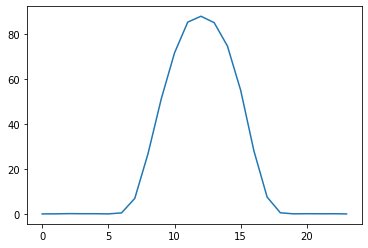

In [16]:
plt.plot(gan.gen.predict(target).flatten())

In [17]:
for i, p in enumerate(gan.gen.predict(target).flatten()):
    print(i+1, round(p*0.7, 2))

1 -0.05
2 -0.02
3 0.04
4 0.02
5 0.02
6 -0.04
7 0.27
8 4.8
9 18.72
10 35.77
11 50.05
12 59.64
13 61.48
14 59.47
15 52.2
16 38.43
17 19.6
18 5.19
19 0.3
20 -0.02
21 0.02
22 -0.0
23 0.01
24 -0.04


In [18]:
for i, p in enumerate(gan.gen.predict(target).flatten()):
    print(i+1, round(p*0.6, 2))

1 -0.04
2 -0.02
3 0.04
4 0.01
5 0.02
6 -0.03
7 0.24
8 4.11
9 16.04
10 30.66
11 42.9
12 51.12
13 52.7
14 50.98
15 44.74
16 32.94
17 16.8
18 4.45
19 0.26
20 -0.02
21 0.02
22 -0.0
23 0.01
24 -0.04


In [19]:
target[:24]

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 2.30973451e-03, 1.13000000e-01,
        2.45902655e-01, 4.20168142e-01, 5.10867257e-01, 4.93522124e-01,
        4.92929204e-01, 4.18672566e-01, 3.72592920e-01, 2.50159292e-01,
        8.99380531e-02, 1.53628319e-02, 9.73451327e-05, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        4.87179487e-01, 6.48648649e-01, 7.22222222e-01, 6.48648649e-01,
        5.52631579e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 3.00000000e-01,
        3.00000000e-01, 2.00000000e-01, 2.00000000e-01, 2.00000000e-01,
        7.50000000e-01, 5.00000000e-01, 3.50000000e-01, 4.50000000e-01,
        6.00000000e-01, 4.68750000e-01, 3.24324324e-01, 1.82926840e-02,
        8.06451570e-02, 1.19170984e-01, 7.10900440e-02, 4.484304